In [1]:
from __future__ import absolute_import, division, print_function
import os
from scipy.io import loadmat
import arff
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.svm import NuSVC, SVC
from sklearn.svm import libsvm
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from collections import Counter

## Feature Paths

In [2]:
FBANK_feat = os.path.join('FBANK','binnedFeat.mat')
FBANK_label = os.path.join('FBANK','binnedLabels.csv')
ComParE_feat = os.path.join('baseline','openSMILEall_PCG.mat')
BOAW_feat = os.path.join('baseline_boaw','feat','boawFeat.4096.arff')
BOAW_meta = os.path.join('baseline_boaw','feat','BOAW_filenames.txt')

In [3]:
def severe2abnormal(labels):
    for idx,each in enumerate(labels):
        if each == 2:
            labels[idx]=1
    return labels

## Data Loading

In [4]:
## Load BoaW fixed

foldnum = 1
codebook = 4096
feat_path = os.path.join('baseline_boaw/feat/')
meta_path = os.path.join('..','..','feature','mfcc')


scaler = StandardScaler()

X = []
y = []
filenames = []

for subset in ['train','dev']:
    BOAW_feat = os.path.join(feat_path,
                             'fold%d.%s.%d.arff' % (foldnum,subset,codebook))
    BOAW_meta = os.path.join(meta_path,'fold%d.%s.filenames.txt' % (foldnum,subset))
    print(BOAW_feat)
    print(os.path.isfile(BOAW_meta))
    
    df = arff.load(open(BOAW_feat,'r'))
    boawData = pd.DataFrame(np.array(df['data'],dtype=float))
    del df

    boawFilenames = []
    with open(BOAW_meta, 'r') as fp:
        line = fp.readline()
        boawFilenames.append(line.split('\n')[0])
        while line:
                line = fp.readline()
                boawFilenames.append(line.split('\n')[0])
    boawFilenames = boawFilenames[:-1]
    boawData['filenames'] = boawFilenames
    boawData.rename({len(boawData.columns)-2:'label'},axis='columns',inplace=True)
    boawData.label = [int(each) for each in boawData.label]
    boawData['dataset'] = [each[-1][0] for each in boawData.filenames.str.split('_')]
    boawData.set_index('filenames',drop=True,inplace=True)
    
    filenames.append(boawFilenames)
    del boawFilenames
    
    X.append(boawData[range(4096)].values)
    y.append(boawData.label.values)
    
    del boawData
    
X = np.vstack(X)
y = np.hstack(y)
filenames = np.hstack(filenames)

boawData = pd.DataFrame(X)
boawData['filenames'] = filenames
boawData['label'] = y
boawData.set_index('filenames',drop=True,inplace=True)
boawData['dataset'] = [each[-1][0] for each in boawData.index.str.split('_')]


del X,y

baseline_boaw/feat/fold1.train.4096.arff
True
baseline_boaw/feat/fold1.dev.4096.arff
True


In [5]:
## Load FBANK: 

df = loadmat(FBANK_feat)
fbankData = pd.DataFrame(df['feats'])
fbankMeta = pd.read_csv(FBANK_label)
fbankMeta.file_name = [each[0] for each in fbankMeta.file_name.str.split('.')]
fbankData = fbankData.join(fbankMeta)
fbankData.dropna(inplace=True)
fbankData.rename({'file_name':'filenames'},axis="columns",inplace=True)
fbankData.label = [int(each) for each in fbankData.label]
fbankData['dataset'] = [each[-1][0] for each in fbankData.filenames.str.split('_')]
fbankData.set_index('filenames',drop=True,inplace=True)

del df, fbankMeta

fbankData.shape

(3835, 2709)

In [6]:
## Load ComParE:

df = loadmat(ComParE_feat)

compareData = pd.DataFrame(df['dataTrain'])
compareData = pd.concat((compareData,pd.DataFrame(df['dataDev'])),axis="rows").reset_index(drop=True)
compareData['label'] = np.concatenate((np.hstack(df['TrainLabels']),np.hstack(df['DevLabels'])),axis=0)
compareData['filenames'] = np.concatenate((np.hstack(df['TrainFiles']),np.hstack(df['DevFiles'])),axis=0)
compareData.filenames = [each[0] for each in compareData.filenames.str.split('.')]
compareData.label = [int(each) for each in compareData.label]
compareData['dataset'] = [each[-1][0] for each in compareData.filenames.str.split('_')]
compareData.set_index('filenames',drop=True,inplace=True)

del df

compareData.shape

(3835, 6375)

In [7]:
## Fuse dataframes

print("Target Size %d" % (len(boawData.columns)-2+len(fbankData.columns)-2+len(compareData.columns)))
fused = boawData[range(len(boawData.columns)-2)].join(fbankData[range(len(fbankData.columns)-2)],rsuffix='fbank')
fused = fused.join(compareData,lsuffix='fused')
fused.dropna()
fused.columns = range(len(fused.columns))
fused.rename({len(fused.columns)-2:'label',len(fused.columns)-1:'dataset'},axis="columns",inplace=True)

del boawData, fbankData, compareData

fused.shape

Target Size 13178


(3153, 13178)

### Random Validation Split

In [ ]:
rand_state = 114
n_estimators = 10
dataset = '0'

scaler = StandardScaler()
mask = fused.dataset == dataset

X = scaler.fit_transform(fused[range(len(fused.columns)-2)][mask]) ## .4489999
y = fused.label[mask]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state = rand_state,
                                                  shuffle = True)

### Dev set of Compare

In [ ]:
rand_state = 1
dataset = '0'

scaler = StandardScaler()
mask1 = fused.dataset == dataset
mask2 = fused[mask1].index.str.contains('train')
mask3 = fused[mask1].index.str.contains('devel')

X = scaler.fit_transform(fused[range(len(fused.columns)-2)][mask1]) ## .4489999
y = fused.label[mask1]

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask3]
y_val = y[mask3]

del mask1, mask2, mask3, X, y

### Fold1_noFIR

In [28]:
rand_state = 114
n_estimators = 5
scaler = StandardScaler()

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation1.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = fold1_data[range(len(fold1_data.columns)-2)]
y = fold1_data.label
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]

del mask, mask1, mask2, X, y

### Fold2_noFIR

In [ ]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation2.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]

del mask, mask1, mask2, X, y

### Fold3_noFIR

In [ ]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation3.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]

del mask, mask1, mask2, X, y

### Fold0_noFIR

In [16]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation0.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = scaler.fit_transform(X[mask2])
# X_train = np.asarray(X[mask2].values)
y_train = y[mask2]
X_val = scaler.transform(X[mask1])
# X_val = np.asarray(X[mask1].values)
y_val = y[mask1]

del mask, mask1, mask2, X, y

In [8]:
def verboseMetrics(y_val,softScores,verbose=True):
    eps = 1.1e-5
    if Counter(y_val).keys()[-1] == 1:
        TN, FP, FN, TP = confusion_matrix(y_val, np.argmax(softScores,axis=-1), labels=[0,1]).ravel()
        sensitivity = TP / (TP + FN + eps)
        specificity = TN / (TN + FP + eps)
        precision = TP / (TP + FP + eps)
        F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
        Macc = (sensitivity + specificity) / 2
        if verbose:
            print("TN:{},FP:{},FN:{},TP:{},Sensitivity:{},Specificity{},Macc:{},F1:{}".format(TN, FP, FN, TP,sensitivity,specificity,Macc,F1))
        return Macc
    elif Counter(y_val).keys()[-1] == 2:
        logs = dict()
        confmat = confusion_matrix(y_pred=np.argmax(softScores,axis=-1), y_true=y_val)
        logs['recall0'] = confmat[0, 0] / np.sum(confmat[0, :])
        logs['recall1'] = confmat[1, 1] / np.sum(confmat[1, :])
        logs['recall2'] = confmat[2, 2] / np.sum(confmat[2, :])
        logs['UAR'] = np.mean([logs['recall0'], logs['recall1'], logs['recall2']])
        if verbose:
            print(logs.items())

## UnderSampling

In [29]:
n_estimators = 100
verbose = False

0.8922806443562159
0.009066401744867019
Posterior Fusion Score:
TN:140,FP:31,FN:3,TP:168,Sensitivity:0.982456077152,Specificity0.818713397627,Macc:0.900584737389,F1:0.908102585643


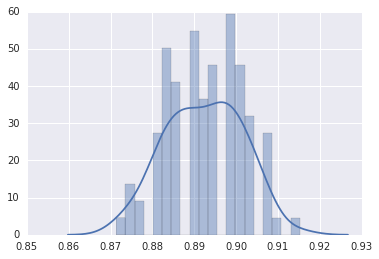

In [30]:
## BOAW

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,:codebook],y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, nu = .5)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,:codebook]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

boaw_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    boaw_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,boaw_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

0.7905847444653088
0.012047208665074924
Posterior Fusion Score:
TN:123,FP:48,FN:22,TP:149,Sensitivity:0.871344973188,Specificity0.719298199343,Macc:0.795321586266,F1:0.809777087776


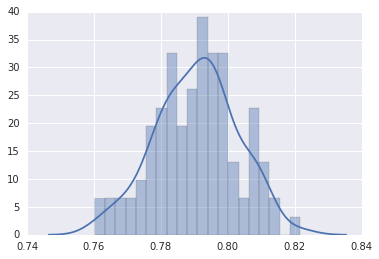

In [ ]:
## Fbank

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook:codebook+2707],y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, nu = .5)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,codebook:codebook+2707]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

fbank_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    fbank_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,fbank_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

In [ ]:
## Compare


np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook+2707:],y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, nu = .5)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,codebook+2707:]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

compare_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    compare_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,compare_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

In [ ]:
weights = [.92,.055,.025]

fusedSoft = boaw_posteriors*weights[0]+fbank_posteriors*weights[1]+compare_posteriors*weights[2]
print("Validation accuracy Fusion %f" % accuracy_score(y_val,
                                                            np.argmax(fusedSoft,axis=-1)))
verboseMetrics(y_val,fusedSoft)

## OverSampling

In [ ]:
n_estimators = 5
verbose = False

In [ ]:
## BOAW

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,:codebook],y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, nu = .5)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,:codebook]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

boaw_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    boaw_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,boaw_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

In [ ]:
## Fbank

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook:codebook+2707],y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, nu = .5)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,codebook:codebook+2707]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

fbank_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    fbank_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,fbank_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

0.8964911704011527
0.0035087717041141146
Posterior Fusion Score:
TN:149,FP:22,FN:13,TP:158,Sensitivity:0.92397654875,Specificity0.871344973188,Macc:0.897660760969,F1:0.900279347506


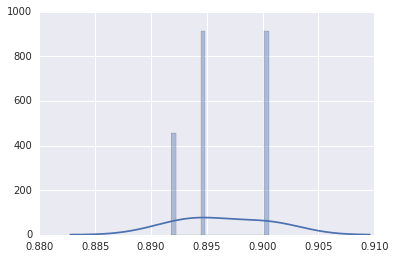

In [14]:
## Compare


np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook+2707:],y_train)
    
    clf = NuSVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, nu = .5)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,codebook+2707:]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

compare_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    compare_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,compare_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()

In [ ]:
weights = [.53,.17,.3]

fusedSoft = boaw_posteriors*weights[0]+fbank_posteriors*weights[1]+compare_posteriors*weights[2]
print("Validation accuracy Fusion %f" % accuracy_score(y_val,
                                                            np.argmax(fusedSoft,axis=-1)))
verboseMetrics(y_val,fusedSoft)

In [ ]:
## Compare

np.random.seed(1)
rand_states = np.random.randint(20000,size=(n_estimators,))

results = []
softScores = []

for idx,rand_state in enumerate(rand_states):
    rus = RandomOverSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_train[:,codebook+2707:],y_train)
    
    clf = SVC(kernel='linear',probability=True,verbose=verbose,
              random_state=rand_state, C = 1)
    if verbose:
        print("Training SVM %d" % idx)
    clf.fit(X,y)
    
    softScores.append(clf.predict_proba(X_val[:,codebook+2707:]))
    results.append(verboseMetrics(y_val,softScores[-1],verbose))
    
    del clf
    
print(np.mean(results))
print(np.std(results))

## Calculate fused posteriors for all the SVMs

compare_posteriors = np.asarray(np.zeros((y_val.shape[0],2)))

for each in softScores:
    compare_posteriors+=each
print("Posterior Fusion Score:")
verboseMetrics(y_val,compare_posteriors)

## Plot distribution of SVM accuracies

sns.distplot(results,20)
plt.show()